<div style="
    background:#ff4da6;
    color:white;
    padding:14px 20px;
    border-radius:12px;
    font-weight:700;
    display:block;
    font-size:18px;
    text-align:center;
    max-width:700px;
    margin:auto;
">
✨ Hello everyone, ✨<br><br>
This notebook presents my implementation of a Pix2Pix-based GAN model.<br>
It includes data preprocessing, model architecture (Generator & Discriminator), training loops, and evaluation functions.<br>
Training was completed successfully, and the notebook is organized so you can easily test different hyperparameters, loss weights, and model settings.<br><br>
🚀 Feel free to explore, modify, and experiment with the code.
</div>



In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/101_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/4_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/26_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/162_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/119_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/72_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/34_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/163_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/47_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/68_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/138_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/177_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/183_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val/161_AB.jpg
/kaggle/input/pix2pix-dataset/edges2shoes

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import time

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Conv2D, Input, MaxPool2D, Conv2DTranspose, concatenate, Lambda, BatchNormalization, Activation, LeakyReLU, ReLU
from keras.utils import img_to_array, load_img, plot_model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.layers import Dropout

from tensorflow.keras import Sequential  # تغییر به tf.keras

from tensorflow.keras.layers import ZeroPadding2D

from tensorflow.keras.initializers import RandomNormal  # اصلاح: از tf.keras.initializers وارد کنید




path = "../input/pix2pix-dataset/maps/maps/train/"
num_images = 1000  # یا len(all_files) برای همه
print("TensorFlow is working:", tf.__version__)

TensorFlow is working: 2.18.0


<div style="background:#ff4da6; color:white; padding:10px 16px; border-radius:8px; font-weight:700; display:inline-block; font-size:18px;">
  augmentation 

</div>

Found 1000 images
First 5 images: ['../input/pix2pix-dataset/maps/maps/train/623.jpg', '../input/pix2pix-dataset/maps/maps/train/764.jpg', '../input/pix2pix-dataset/maps/maps/train/1075.jpg', '../input/pix2pix-dataset/maps/maps/train/771.jpg', '../input/pix2pix-dataset/maps/maps/train/208.jpg']


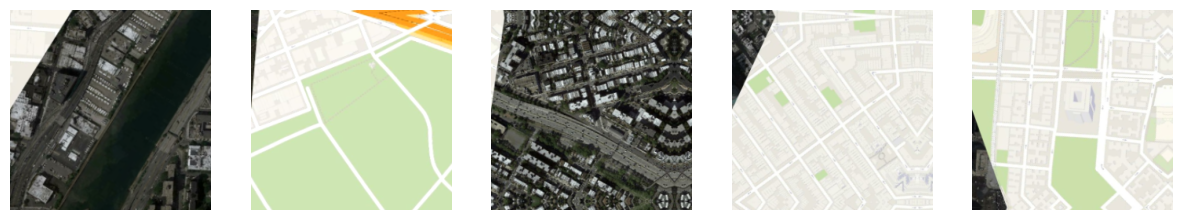

In [18]:
# List of files
all_files = glob(os.path.join(path, "*.jpg")) + glob(os.path.join(path, "*.png"))
image_files = all_files[:num_images]


print(f"Found {len(image_files)} images")
print("First 5 images:", image_files[:5])


# Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])


# ================================
   # Image processing function
# ================================
def process_image(file_path):

    # load
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # split
    w = tf.shape(image)[1] // 2
    real_image = image[:, w:, :]
    input_image = image[:, :w, :]

    # resize
    input_image = tf.image.resize(input_image, [256, 256])
    real_image  = tf.image.resize(real_image,  [256, 256])

    # join for augmentation
    stacked = tf.concat([input_image, real_image], axis=1)
    stacked = data_augmentation(stacked)

    # split again
    input_image = stacked[:, :256, :]
    real_image  = stacked[:, 256:, :]

    # normalize [-1,1]
    input_image = (tf.cast(input_image, tf.float32) / 127.5) - 1
    real_image  = (tf.cast(real_image, tf.float32) / 127.5) - 1

    return (input_image, real_image)



# ================================
#     Dataset
# ================================
dataset = tf.data.Dataset.from_tensor_slices(image_files)
dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

dataset = (
    dataset.shuffle(1000)
           .batch(32)
           .prefetch(tf.data.AUTOTUNE)
)



# ================================
#     Test batch
# ================================
for input_batch, real_batch in dataset.take(1):
    plt.figure(figsize=(15, 5))
    for i in range(min(5, real_batch.shape[0])):
        img = (real_batch[i] + 1) / 2
        plt.subplot(1, 5, i + 1)
        plt.imshow(img.numpy())
        plt.axis('off')
    plt.show()


<div style="background:#ff4da6; color:white; padding:10px 16px; border-radius:8px; font-weight:700; display:inline-block; font-size:18px;">
  Pix2Pix Model
</div>



<div style="background:#ff4da6; color:white; padding:10px 16px; border-radius:8px; font-weight:700; display:inline-block; font-size:18px;">
 generator (U-Net architecture)
</div>


In [33]:

def build_generator(image_shape=(256, 256, 3)):
    def downsample(filters, size, apply_batchnorm=True):
        init = RandomNormal(stddev=0.02)
        layer = Sequential()
        layer.add(Conv2D(filters, size, strides=2, padding='same', kernel_initializer=init, use_bias=False))
        if apply_batchnorm:
            layer.add(BatchNormalization())
        layer.add(LeakyReLU())
        return layer
    
    def upsample(filters, size, apply_dropout=False):
        init = RandomNormal(stddev=0.02)
        layer = Sequential()
        layer.add(Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=init, use_bias=False))
        layer.add(BatchNormalization())
        if apply_dropout:
            layer.add(Dropout(0.5))
        layer.add(ReLU())
        return layer
    
    inputs = Input(shape=image_shape)
    
    # Encoder (downsampling)
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    
    # Decoder (upsampling)
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 512)
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    
    init = RandomNormal(stddev=0.02)
    last = Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=init, activation='tanh')
    
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concatenate([x, skip])
    
    x = last(x)
    return Model(inputs=inputs, outputs=x)

generator = build_generator(image_shape=(256, 256, 3))



<div style="background:#ff4da6; color:white; padding:10px 16px; border-radius:8px; font-weight:700; display:inline-block; font-size:18px;">
 discriminator (PatchGAN)</div>


In [34]:
def build_discriminator(image_shape=(256, 256, 3)):
    init = RandomNormal(stddev=0.02)
    inp = Input(shape=image_shape, name='input_image')
    tar = Input(shape=image_shape, name='target_image')

    
    x = concatenate([inp, tar])  # (bs, 256, 256, 6)
    
    down1 = Conv2D(64, 4, strides=2, padding='same', kernel_initializer=init)(x)
    down1 = LeakyReLU()(down1)
    
    down2 = Conv2D(128, 4, strides=2, padding='same', kernel_initializer=init)(down1)
    down2 = BatchNormalization()(down2)
    down2 = LeakyReLU()(down2)
    
    down3 = Conv2D(256, 4, strides=2, padding='same', kernel_initializer=init)(down2)
    down3 = BatchNormalization()(down3)
    down3 = LeakyReLU()(down3)
    
    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(512, 4, strides=1, kernel_initializer=init, use_bias=False)(zero_pad1)
    batchnorm1 = BatchNormalization()(conv)
    leaky_relu = LeakyReLU()(batchnorm1)
    
    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides=1, kernel_initializer=init)(zero_pad2)
    
    return Model(inputs=[inp, tar], outputs=last)

# Test building the model (to check for errors)
discriminator = build_discriminator()
print(discriminator.summary())  
discriminator = build_discriminator(image_shape=(256, 256, 3))


Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 128, 128,  │      6,208 │ concatenate_20[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_40      │ (None, 128, 128,  │          0 │ conv2d_46[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 64, 64,    │    131,200 │ leaky_re_lu_40[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_47[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_41      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 32, 32,    │    524,544 │ leaky_re_lu_41[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_42      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_12   │ (None, 34, 34,    │          0 │ leaky_re_lu_42[0… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 31, 31,    │  2,097,152 │ zero_padding2d_1… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_43      │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_13   │ (None, 33, 33,    │          0 │ leaky_re_lu_43[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_1

 Total params: 2,770,881 (10.57 MB)

 Trainable params: 2,769,089 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

None





<div style="background:#ff4da6; color:white; padding:10px 16px; border-radius:8px; font-weight:700; display:inline-block; font-size:18px;">
 Optimizer
    (Optimizers) , (Loss Functions)</div>

In [35]:
# optimizer

generator_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_optimizer = Adam(2e-4, beta_1=0.5)

# lossها
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + (100 * l1_loss)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(disc_generated_output), disc_generated_output)
    return (real_loss + generated_loss) / 2



<div style="background:#ff4da6; color:white; padding:10px 16px; border-radius:8px; font-weight:700; display:inline-block; font-size:18px;">
Train Step</div>

In [36]:
# train step
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))


<div style="background:#ff4da6; color:white; padding:10px 16px; border-radius:8px; font-weight:700; display:inline-block; font-size:18px;">
Train Loop
</div>

In [37]:
# Training loop with epochs
epochs = 20  # 
for epoch in range(epochs):
    start = time.time()
    print(f"Epoch {epoch+1}/{epochs}")
    for input_image, target in dataset:
        train_step(input_image, target)
    print(f"Time for epoch {epoch+1}: {time.time() - start} sec")

Epoch 1/20


E0000 00:00:1763888051.580499      48 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_41_1/sequential_27_1/dropout_3_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Time for epoch 1: 61.78039813041687 sec
Epoch 2/20
Time for epoch 2: 45.836331367492676 sec
Epoch 3/20
Time for epoch 3: 46.41880941390991 sec
Epoch 4/20
Time for epoch 4: 47.11470317840576 sec
Epoch 5/20
Time for epoch 5: 47.51491117477417 sec
Epoch 6/20
Time for epoch 6: 47.8453574180603 sec
Epoch 7/20
Time for epoch 7: 47.839786529541016 sec
Epoch 8/20
Time for epoch 8: 48.22127032279968 sec
Epoch 9/20
Time for epoch 9: 48.121535778045654 sec
Epoch 10/20
Time for epoch 10: 48.00886631011963 sec
Epoch 11/20
Time for epoch 11: 47.44525957107544 sec
Epoch 12/20
Time for epoch 12: 47.32076835632324 sec
Epoch 13/20
Time for epoch 13: 46.83587598800659 sec
Epoch 14/20
Time for epoch 14: 46.8841655254364 sec
Epoch 15/20
Time for epoch 15: 46.97684168815613 sec
Epoch 16/20
Time for epoch 16: 46.67875099182129 sec
Epoch 17/20
Time for epoch 17: 46.802863359451294 sec
Epoch 18/20
Time for epoch 18: 46.62351703643799 sec
Epoch 19/20
Time for epoch 19: 46.86316657066345 sec
Epoch 20/20
Time for



<div style="background:#ff4da6; color:white; padding:10px 16px; border-radius:8px; font-weight:700; display:inline-block; font-size:18px;">
Checkpoint saved 
</div>

In [38]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")


In [39]:
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)






<div style="background:#ff4da6; color:white; padding:10px 16px; border-radius:8px; font-weight:700; display:inline-block; font-size:18px;">
Checkpoint saved ✔
    
</div>

In [40]:
if (epoch + 1) % 5 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)
    print("Checkpoint saved ✔")


Checkpoint saved ✔




<div style="background:#ff4da6; color:white; padding:10px 16px; border-radius:8px; font-weight:700; display:inline-block; font-size:18px;">
Evaluation

    
</div>

In [41]:
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim
import numpy as np

def evaluate_model(generator, dataset):
    psnr_values = []
    ssim_values = []

    for input_image, target_image in dataset.take(50):  # 50 batch تست
        pred = generator(input_image, training=False)

        # برگرداندن تصاویر از [-1,1] به [0,255]
        pred = ((pred[0] + 1) * 127.5).numpy().astype(np.uint8)
        real = ((target_image[0] + 1) * 127.5).numpy().astype(np.uint8)

        # PSNR
        psnr_values.append(
            tf.image.psnr(pred, real, max_val=255).numpy()
        )

        # SSIM
        # channel_axis=2 برای تصویر رنگی (H, W, C)
        ssim_values.append(
            ssim(pred, real, channel_axis=2, data_range=255)
        )

    print("📌 Average PSNR:", np.mean(psnr_values))
    print("📌 Average SSIM:", np.mean(ssim_values))
    print("✔ Evaluation completed.")


In [42]:
evaluate_model(generator, dataset)


📌 Average PSNR: 17.39272
📌 Average SSIM: 0.42753401499384475
✔ Evaluation completed.
